## 1. Business Understanding
The goal of this project is to predict whether an individual received the H1N1 vaccine using survey data from the National 2009 H1N1 Flu Survey. This analysis will help public health agencies identify patterns in demographics, health behaviors, and opinions to better target vaccination campaigns and allocate resources effectively.

To solve this problem, I will use data science tools such as data cleaning and preprocessing, exploratory data analysis, and machine learning models (logistic regression and decision trees) to build and evaluate predictive models for vaccination behavior.
- Why classification is appropriate

## 2. Data Understanding
The dataset comes from the National 2009 H1N1 Flu Survey and contains information on respondents’ demographics, health status, opinions about vaccines, and health-related behaviors. Key features include age, sex, race, education, chronic health conditions, perceived risk of H1N1, and previous vaccination history.

The target variable is h1n1_vaccine (1 = vaccinated, 0 = not vaccinated). Initial steps include examining feature distributions, handling missing values, encoding categorical variables, and exploring relationships between features and the target to guide model building.

## Data Preparation

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

df_features = pd.read_csv('./data/training_set_features.csv')
df_labels = pd.read_csv('./data/training_set_labels.csv')

# merging features and labels dataframes on 'respondent_id'
df = pd.merge(df_features, df_labels, on='respondent_id')
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [2]:
df['census_msa'].value_counts()

MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: census_msa, dtype: int64

In [3]:
df.isna().sum().sort_values(ascending=False)    

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_adults                 249
household_children               249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowledge                   116
h1n1_concern                      92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

### Dropping Columns
 - Employment Occupation, employment_industry and health_insurance have a high number of missing values(about 50%)so we will drop those.
 - Also dropping census_msa and hhs_geo region as they will not be relevant to our analysis.

In [4]:
#dropping columns with high missing values
df = df.drop(["employment_occupation","employment_industry","health_insurance","census_msa","hhs_geo_region"], axis=1)
df.isna().sum().sort_values(ascending=False)    

income_poverty                 4423
doctor_recc_h1n1               2160
doctor_recc_seasonal           2160
rent_or_own                    2042
employment_status              1463
marital_status                 1408
education                      1407
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_seas_sick_from_vacc     537
opinion_seas_risk               514
opinion_seas_vacc_effective     462
opinion_h1n1_sick_from_vacc     395
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
household_adults                249
household_children              249
behavioral_avoidance            208
behavioral_touch_face           128
h1n1_knowledge                  116
h1n1_concern                     92
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_antiviral_meds        71
behavioral_wash_hands            42
behavioral_face_mask             19
seasonal_vaccine            

## Train-Test Split
As we have decided our target is h1n1 vaccine, we're going to set out X and y variables and perform a train-test split before doing anymore data cleaning to prevent data leakage.

In [5]:
X = df.drop(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y = df['h1n1_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

## Preprocessing
-  Filling in Categorical columns(with missing values) with the most frequently occuring value
- Filling in Numerical columns(with missing values) with the median.  

In [6]:
# Initializing a simple Imputer to fill missing values
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Separating numerical and categorical columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Imputing missing numerical values
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])

# Imputing missing categorical values
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

# Verifying no missing values remain
print(X_train.isna().sum().sum())
print(X_test.isna().sum())

0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
household_adults               0
household_children             0
dtype: i

## Exploratory Data Analysis

In [7]:
# In order to perform EDA on the training set with labels we need to concatenate X_train and y_train
df_eda = pd.concat([X_train, y_train], axis=1)
df_eda.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,household_adults,household_children,h1n1_vaccine
24706,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Some College,White,Female,Below Poverty,Married,Rent,Unemployed,1.0,0.0,0
5393,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,College Graduate,White,Male,"> $75,000",Not Married,Own,Employed,0.0,0.0,0
20898,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,College Graduate,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,1.0,1.0,1
3429,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,College Graduate,Other or Multiple,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,0.0,0.0,0
8731,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,College Graduate,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,1.0,1.0,0


"Initially, I examined demographic factors like Age and Education, but found they only accounted for a 2-5% difference in vaccination rates. This led me to pivot my analysis toward behavioral and opinion-based features, where I found much stronger indicators, such as doctor recommendations, which increased the vaccination rate by 40%."

## Data Question 1: Health Worker Status Vs Doctor's recommendation
- Does being a health worker(meaning high exposure to the virus and more knowledge of virus) improve chances that they will get the vaccine more than a doctor's recommendation? Which is the stronger
motivation : Doctor's authority or Knowledge of risk


<ipython-input-14-94d502fc5917>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.barplot(x='health_worker', y='h1n1_vaccine', hue='doctor_recc_h1n1', data=df_eda, palette='viridis', ci=None)


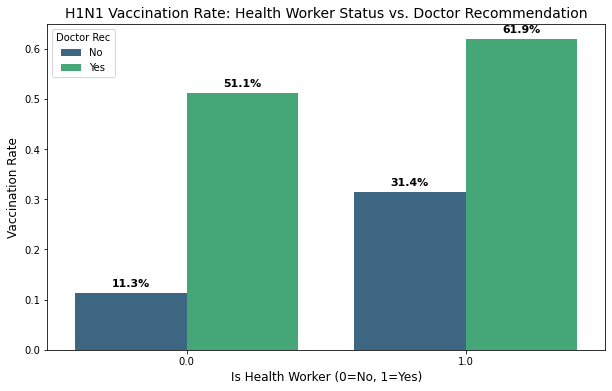

In [14]:
import seaborn as sns
plt.figure(figsize=(10, 6))

def add_percentage_labels(ax):
    for p in ax.patches:
        # The height of the bar is the actual percentage value (e.g., 0.532)
        height = p.get_height()
        # Create the label text (e.g., '53.2%')
        label_text = f'{height:.1%}'
        
        # Annotate the plot
        ax.annotate(label_text, 
                    # Position the text at the top-center of the bar
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', 
                    xytext=(0, 10), # Offset text 10 points above the bar
                    textcoords='offset points',
                    fontsize=11, 
                    fontweight='bold')

ax1 = sns.barplot(x='health_worker', y='h1n1_vaccine', hue='doctor_recc_h1n1', data=df_eda, palette='viridis', ci=None)
add_percentage_labels(ax1)
plt.title('H1N1 Vaccination Rate: Health Worker Status vs. Doctor Recommendation', fontsize=14)
plt.xlabel('Is Health Worker (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Vaccination Rate', fontsize=12)
plt.legend(title='Doctor Rec', labels=['No', 'Yes'])
plt.show()

**Insight** - While health workers are generally more likely to be vaccinated than the general public, a doctor's recommendation is a far more powerful driver than professional status alone. A non-health worker who receives a recommendation is significantly more likely (~52%) to get vaccinated than a health worker who does not receive one (~20%). Even among health workers, a recommendation boosts the vaccination rate from 20% to over 64%.

**Recomendation** - Even for populations with high health literacy (like health workers), Public health campaigns should focus on institutionalizing recommendations. Hospitals and clinics should implement "standing orders" or mandatory consultation prompts for all staff and patients, ensuring that every individual—regardless of their background—receives a formal verbal recommendation from a peer or superior.

## Opinion of Vaccine Effectiveness vs Vaccination Rate

<ipython-input-15-6959bcd4076e>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax2 = sns.barplot(x='opinion_h1n1_vacc_effective', y='h1n1_vaccine', data=df_eda, palette='coolwarm', ci=None)


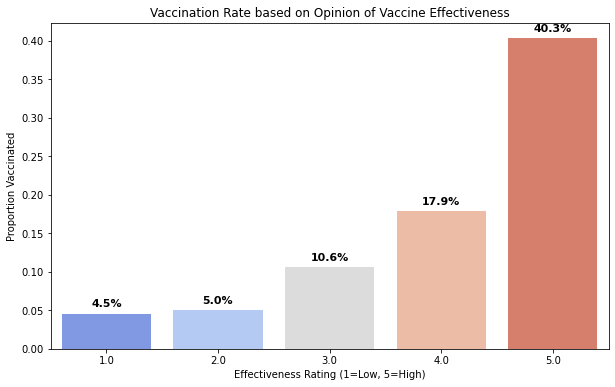

In [15]:
# 3. Opinions vs. Vaccination
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='opinion_h1n1_vacc_effective', y='h1n1_vaccine', data=df_eda, palette='coolwarm', ci=None)
add_percentage_labels(ax2)
plt.title('Vaccination Rate based on Opinion of Vaccine Effectiveness')
plt.xlabel('Effectiveness Rating (1=Low, 5=High)')
plt.ylabel('Proportion Vaccinated')
plt.show()

**Insight**: There is a "threshold effect" regarding trust in the vaccine. Vaccination rates remain stagnant and low for anyone who rates effectiveness between 1 and 3. However, there is a massive surge in uptake once an individual’s confidence reaches a "4" or "5." Essentially, if a person isn't fully convinced the vaccine is highly effective, they are unlikely to take the "risk" or effort to get it.

**Recommendation**: Marketing and educational materials should move away from "general awareness" and focus specifically on efficacy data. To move the needle, the goal must be to shift "neutrals" (3s) into "believers" (5s). Use clear, transparent infographics showing the percentage of prevented hospitalizations or infections. Addressing the "It might not even work" mindset is the key to unlocking higher vaccination numbers. 



<ipython-input-17-5398b12b1eda>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax3 = sns.barplot(x='opinion_h1n1_risk', y='h1n1_vaccine', data=df_eda, palette='coolwarm', ci=None)


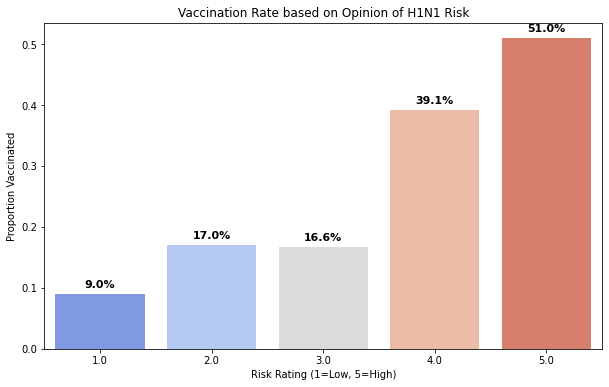

In [17]:
plt.figure(figsize=(10, 6))
ax3 = sns.barplot(x='opinion_h1n1_risk', y='h1n1_vaccine', data=df_eda, palette='coolwarm', ci=None)
add_percentage_labels(ax3)
plt.title('Vaccination Rate based on Opinion of H1N1 Risk')
plt.xlabel('Risk Rating (1=Low, 5=High)')
plt.ylabel('Proportion Vaccinated')
plt.show()

**Insight**: Perceived personal risk is a primary psychological trigger for action. Individuals who perceive their risk as "Low" (1 or 2) have a vaccination rate below 17%. Conversely, those who perceive their risk as "Very High" (5) have a vaccination rate exceeding 50%. This suggests that many people skip the vaccine not because they are "anti-vax," but because they simply don't believe the virus poses a threat to them personally.

**Recommendation**: The business should adopt a segmented communication strategy based on personal risk factors. Instead of a "one-size-fits-all" message, create targeted content that helps individuals identify their own risk (e.g., "If you have X condition or work in Y environment, your risk is high"). By making the threat feel "personal" rather than "theoretical," you can move people from the low-uptake categories into the high-uptake categories.